### **Thay đổi kích thước ảnh bằng phương pháp "Seam Carving"**

### Nhóm thực hiện :

**Bùi Chí Dũng - 1712364**

**Chung Kiệt Phong - 1712657**



In [1]:
# Đoạn code Python để hiển thị file ảnh pnm ở notebook
# Ví dụ để hiển thị file "img.pnm", ở dòng cuối của code cell
# bạn gõ (không cần dấu ! đằng trước): show_pnm('img.pnm')
# LƯU Ý: bạn phải chạy cell này một lần thì mới gọi được hàm show_pnm
from PIL import Image
import numpy as np
def show_pnm(file_name):
  with open(file_name, 'r') as f:
    vals = f.read().split()
  w = int(vals[1])
  h = int(vals[2])
  if vals[0] == 'P2': # Grayscale
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w))
  elif vals[0] == 'P3': # RGB
    pixels = np.array(vals[4:], dtype=np.uint8).reshape((h, w, 3))
  else:
    return None
  
  return Image.fromarray(pixels)

# Đoạn code Python để hiển thị file chứa ma trận ở notebook
# (một dòng của ma trận ứng với một dòng trong file, 
# các phần tử trên mỗi dòng được cách nhau bởi khoảng trắng) 
# Ví dụ để hiển thị file "pixel_importance.txt", ở dòng cuối của code cell
# bạn gõ: show_matrix('pixel_important.txt')
def show_matrix(matrix_file):
  m = np.loadtxt(matrix_file)
  m = m + m.min()
  m = m / m.max()
  m = m * 255
  m = m.astype(np.uint8)
  return Image.fromarray(m)

# 1/ Mô tả ứng dụng
#### Ứng dụng mà nhóm chọn : Seam Carving
- Input : Ảnh RGB.
- Output : Ảnh RGB đã được thay đổi kích thước mà **không làm biến dạng các đối tượng quan trọng**.
- Ý nghĩa của ứng dụng : một use case là ta có thể muốn có các phiên bản với các kích thước khác nhau của cùng một tấm ảnh để hiển thị trên các thiết bị khác nhau (máy tính, điện thoại, ...)

#### Ứng dụng này có cần tăng tốc không? Cần, ứng dụng này chạy chậm khi cài đặt tuần tự.

# 2/ Cài đặt tuần tự
### Thiết kế : Được chia làm 4 bước :
1. Tính độ quan trọng của các pixel bằng hàm phát hiện biên cạnh.
2. Tính các seam bằng độ quan trọng của các pixel.
3. Tìm seam ít quan trọng nhất.
4. Xóa các pixel nằm trên seam ít quan trọng nhất trên hình.

### Đánh giá :
- #### Kịch bản thí nghiệm : Thí nghiệm trên ảnh 640 x 434 với kích thước thay đổi là 100.
- #### Có đúng không? Kết quả chạy được đúng như mong đợi.
- #### Chạy code :

In [5]:
!nvcc source_ver_3.cu -o source_3

source_ver_3.cu(502): warning: conversion from a string literal to "char *" is deprecated

source_ver_3.cu(704): warning: conversion from a string literal to "char *" is deprecated

source_ver_3.cu(502): warning: conversion from a string literal to "char *" is deprecated

source_ver_3.cu(704): warning: conversion from a string literal to "char *" is deprecated



In [6]:
!./source_3 in.pnm host 32 32 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15812263936 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Host time: 
5319.583984 ms


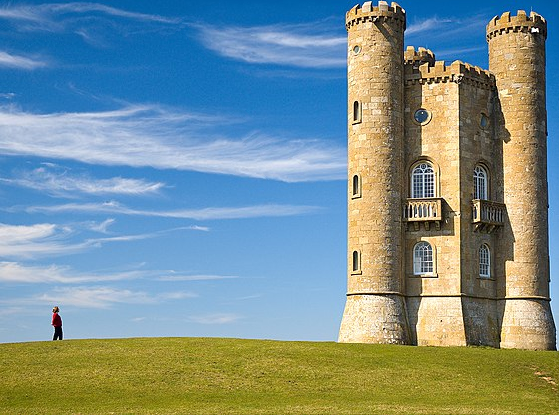

In [7]:
show_pnm("seam_removed.pnm")

# 3/ Cài đặt song song
### Phân tích : 
- Các bước 1, 2, 4 là các bước được song song hóa.
- Do quá trình thực hiện trên các điểm ảnh của các bước này có thể song song hoàn toàn (bước 1, 4) hoặc song song 1 phần (bước 2) cho nên tiến hành song song hóa những bước này.

### Thiết kế : 
- Bước 1 : Tham khảo từ bài làm mờ ảnh ở bài tập 3, mỗi thread được phân để tính giá trị cho một điểm ảnh, điểm khác biệt là filter lúc này bao gồm cả 2 filterX và filterY và kết quả lả tổng giá trị tính được sau khi tính tích chập từ 2 filter này với điểm ảnh.
- Bước 2 : Thực hiện tính độ quan trọng ít nhất tính từ dưới cùng bằng cách chạy vòng lặp (height-1 lần), với mỗi vòng lặp thì mỗi thread sẽ được phân bố tính độ quan trọng cho 1 điểm ảnh trong các điểm ảnh ở hàng ngang. Cho nên kích thước grid (gridSize_2) lúc này sẽ thay đổi do chỉ chạy song song từng hàng ngang trong cả ảnh.
- Bước 3 : Mỗi thread sẽ xử lý một điểm ảnh. Dựa vào mảng seam nhận được, tính toán vị trí của điểm ảnh hiện tại sẽ trở thành vị trí nào sau khi xóa các pixel thuộc vị trí trong mảng seam sau đó gán điểm ảnh hiện tại vào vị trí đó vào ma trận xuất (outPixels).


Lưu ý: Đối với bước tìm min seam (Bước 3), không thể làm song song bởi vì khi chọn lấy một vị trí bất kì thì chúng ta không thể biết được vị trí trước nó để tạo thành một seam liên tục. Trong đó, một điểm có thể được 3 điểm bên trên chọn, còn điểm bên dưới sẽ chỉ có một, vì đã xây dựng ma trận seam trước đó.
### Đánh giá :
- #### Kịch bản thí nghiệm : Thí nghiệm trên ảnh 640 x 434 với kích thước thay đổi là 100.
- #### Có đúng không? Kết quả chạy được đúng như mong đợi.
- #### Chạy code :

In [8]:
!nvcc source_ver_1.cu -o source_1

source_ver_1.cu(408): warning: conversion from a string literal to "char *" is deprecated

source_ver_1.cu(524): warning: conversion from a string literal to "char *" is deprecated

source_ver_1.cu(411): warning: parameter "outPixels" was set but never used

source_ver_1.cu(408): warning: conversion from a string literal to "char *" is deprecated

source_ver_1.cu(524): warning: conversion from a string literal to "char *" is deprecated



In [9]:
!./source_1 in.pnm kernel 32 32 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15812263936 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Kernel time: 
315.586151 ms


In [13]:
!nvcc source_ver_2.cu -o source_2

source_ver_2.cu(499): warning: conversion from a string literal to "char *" is deprecated

source_ver_2.cu(615): warning: conversion from a string literal to "char *" is deprecated

source_ver_2.cu(502): warning: parameter "outPixels" was set but never used

source_ver_2.cu(499): warning: conversion from a string literal to "char *" is deprecated

source_ver_2.cu(615): warning: conversion from a string literal to "char *" is deprecated



In [22]:
!./source_2 in.pnm kernel 32 32 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15812263936 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Kernel time: 
563.146423 ms


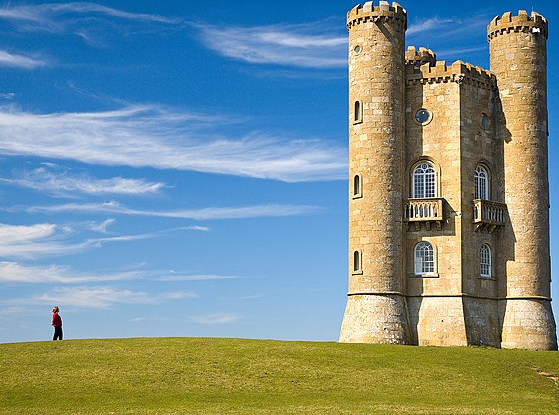

In [24]:
show_pnm("d_seam_removed.pnm")

# 4/ Cài đặt song song + tối ưu hóa
### Phân tích : 
- Hàm kernel thực hiện xóa các điểm ảnh thuộc seam (Bước 4) được tối ưu vì thuật toán ban đầu là mỗi pixels phải duyệt qua từng phần tử trong mảng seam để xác định được vị trí sau khi xóa seam cho nên cần được tối ưu để giảm số lần duyệt seam lại hoặc chỉ duyệt một lần duy nhất.

### Thiết kế : 
- Vì mỗi một seam chỉ có một dòng cho nên giá trị dòng cũng là sẽ là index của seam, cho nên thay vì duyệt từng phần tử trong seam thì chỉ cần dùng trực tiếp giá trị dòng cũng chính là index của seam để tính bước nhảy cho các điểm ảnh sau khi đã xóa seam.

### Đánh giá :
- #### Kịch bản thí nghiệm : Thí nghiệm trên ảnh 640 x 434 với kích thước thay đổi là 100.
- #### Có đúng & nhanh hơn không? Kết quả chạy được đúng như mong đợi và tốc độ cũng đã nhanh lên một chút so với ban đầu.
- #### Chạy code :

In [25]:
!./source_3 in.pnm kernel 32 32 100

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15812263936 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Kernel time: 
492.213470 ms


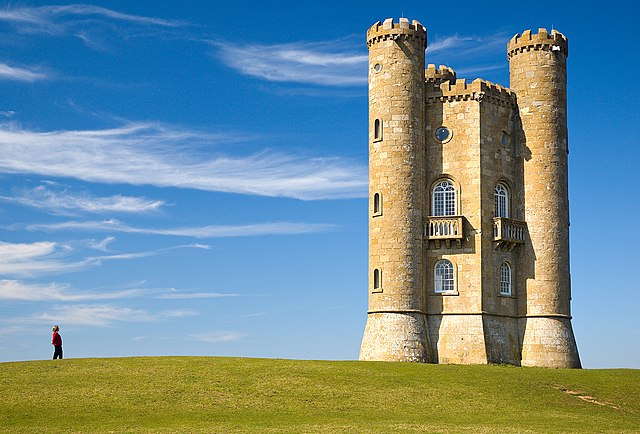

In [26]:
show_pnm("in.pnm")

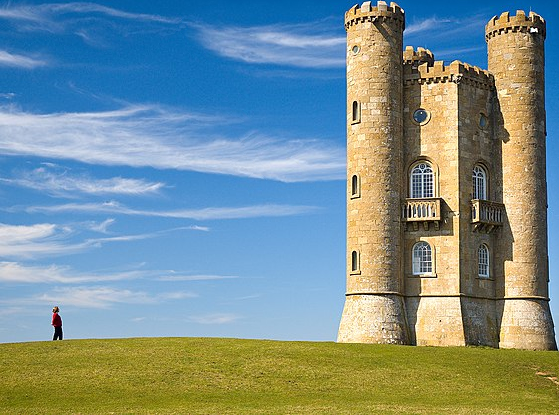

In [27]:
show_pnm("d_seam_removed.pnm")

In [28]:
!./source_3 in.pnm kernel 32 32 300

**********GPU info**********
Name: Tesla T4
Compute capability: 7.5
Num SMs: 40
Max num threads per SM: 1024
Max num warps per SM: 32
GMEM: 15812263936 bytes
CMEM: 65536 bytes
L2 cache: 4194304 bytes
SMEM / one SM: 65536 bytes
****************************

Image size (width x height): 640 x 434
Kernel time: 
926.129700 ms


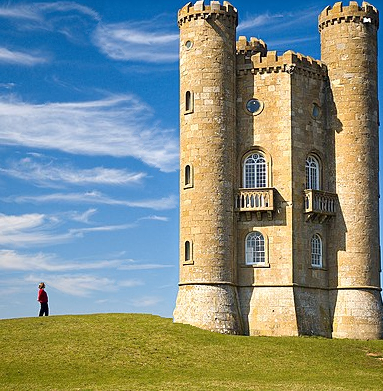

In [29]:
show_pnm("d_seam_removed.pnm")

# 5/ Nhìn lại quá trình làm đồ án
Khó khăn: Khi debug trên cuda, gần như không thể debug để tìm ra lỗi sai, chỉ có thể print từng dòng thủ công để kiểm tra output của các đoạn code.

Hữu ích: nắm được một kĩ thuật xử lý ảnh quan trọng đó là thay đổi kích thước ảnh, bỏ đi những seam ít quan trọng từ việc tính toán và tìm ra seam ít quan trọng nhất. Ngoài ra là kiến thức về xử lý song song, tối ưu hóa chương trình, tối ưu đáng kể thời gian thực thi của chương trình.

Ứng dụng việc thay đổi kích thước ảnh bằng cách sử dụng "Seam Carving" có thể giúp thay đổi kích thước mà vẫn giữ được những chi tiết quan trọng của ảnh, tuy nhiên ít nhiều khi thực hiện lượt bỏ đi một số lượng đáng kể nhiều seam thì ảnh bị bóp mèo là không tránh khỏi. Nhóm sẽ tìm hiểu để sau khi thực hiện việc thay đổi kích thước này có thể scale lại để ảnh ổn nhất có thể. Cũng như một hướng tìm hiểu khác đó là từ việc tính seam ít quan trọng để lược bỏ, ta có thể vừa dùng "Seam Carving" vừa detect main object để tách, và cắt ảnh lấy ra ảnh của chủ thể chính. Theo ví dụ ảnh bên trên đồ án, ta sẽ tách lấy người và tòa lâu đài.

# 6/ Tài liệu tham khảo
- https://www.youtube.com/watch?v=ALcohd1q3dk
- 14_15-DoAnCK.pdf từ thùng chứa tài liệu học tập
